In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Setting a consistent random seed
SEED = 42
np.random.seed(SEED)

In [3]:
# Load Dataset
train_data = pd.read_csv('/Users/vedangmehta/Downloads/nlp-getting-started/train.csv')
test_data = pd.read_csv('/Users/vedangmehta/Downloads/nlp-getting-started/test.csv')

In [4]:
# Exploratory Data Analysis (EDA)
print("Train Data Overview:")
print(train_data.head())
print("\nDataset Info:")
train_data.info()
print("\nMissing Values:\n", train_data.isnull().sum())

Train Data Overview:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Miss

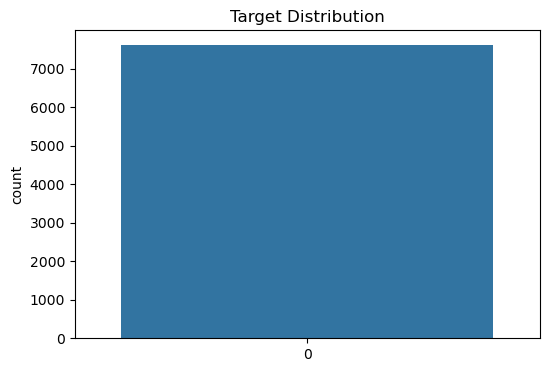

In [5]:
# Visualizing Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(train_data['target'])
plt.title("Target Distribution")
plt.show()

In [6]:
# Text Preprocessing
import re
import string

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags
    return text

train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)


In [7]:
# Tokenization and Padding
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_data['clean_text'])

X = tokenizer.texts_to_sequences(train_data['clean_text'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = train_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [8]:
# Model Building
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.6484 - loss: 0.6119 - val_accuracy: 0.7951 - val_loss: 0.4518
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8856 - loss: 0.3042 - val_accuracy: 0.7932 - val_loss: 0.4821
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9276 - loss: 0.2117 - val_accuracy: 0.7741 - val_loss: 0.6153
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9591 - loss: 0.1288 - val_accuracy: 0.7636 - val_loss: 0.6565
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9689 - loss: 0.0925 - val_accuracy: 0.7577 - val_loss: 0.7807


In [10]:
# Evaluation
val_preds = model.predict(X_val).round().astype(int)
print("\nClassification Report:\n", classification_report(y_val, val_preds))
print("Accuracy Score:", accuracy_score(y_val, val_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       874
           1       0.73      0.69      0.71       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

Accuracy Score: 0.757715036112935


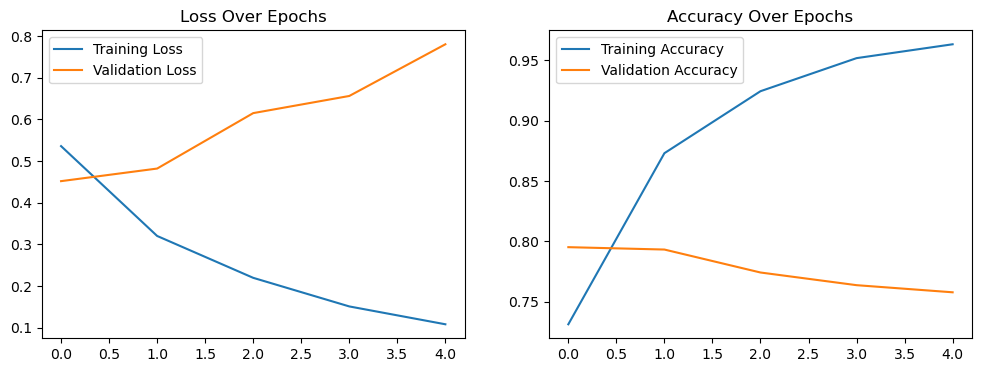

In [11]:
# Visualizing Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()


In [12]:
# Preparing Submission for Kaggle
test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

test_preds = model.predict(test_padded).round().astype(int)
submission = pd.DataFrame({'id': test_data['id'], 'target': test_preds.ravel()})
submission.to_csv('/Users/vedangmehta/Downloads/nlp-getting-started/submission.csv', index=False)
print("Submission file created as submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Submission file created as submission.csv
